In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("LoanApprovalPrediction.csv")  # replace with your dataset path

# Preview dataset
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Define target and features
target = 'Loan_Status'  # change if your target column name differs

num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
cat_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

X = df[num_cols + cat_cols]
Y = df[target].map({'Y': 1, 'N': 0})  # encode target as 1/0


In [4]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Training samples: 418, Test samples: 180


In [5]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Numeric imputer
num_imputer = SimpleImputer(strategy='median')

# Fit on training numeric features
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_cols]), columns=num_cols)
X_test_num = pd.DataFrame(num_imputer.transform(X_test[num_cols]), columns=num_cols)


In [6]:
from sklearn.preprocessing import OneHotEncoder

# Fill missing categorical values
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = pd.DataFrame(cat_imputer.fit_transform(X_train[cat_cols]), columns=cat_cols)
X_test_cat = pd.DataFrame(cat_imputer.transform(X_test[cat_cols]), columns=cat_cols)

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_enc = pd.DataFrame(encoder.fit_transform(X_train_cat),
                               columns=encoder.get_feature_names_out(cat_cols))
X_test_cat_enc = pd.DataFrame(encoder.transform(X_test_cat),
                              columns=encoder.get_feature_names_out(cat_cols))



In [7]:
# Concatenate numeric and encoded categorical features
X_train_processed = pd.concat([X_train_num, X_train_cat_enc], axis=1)
X_test_processed = pd.concat([X_test_num, X_test_cat_enc], axis=1)

print(f"Processed training shape: {X_train_processed.shape}")


Processed training shape: (418, 20)


In [8]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train_processed, Y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [28]:
import joblib

joblib.dump(rf_model, "loan_model.pkl")

['loan_model.pkl']

Accuracy: 0.7944
Precision: 0.8042
Recall: 0.9274
F1-score: 0.8614


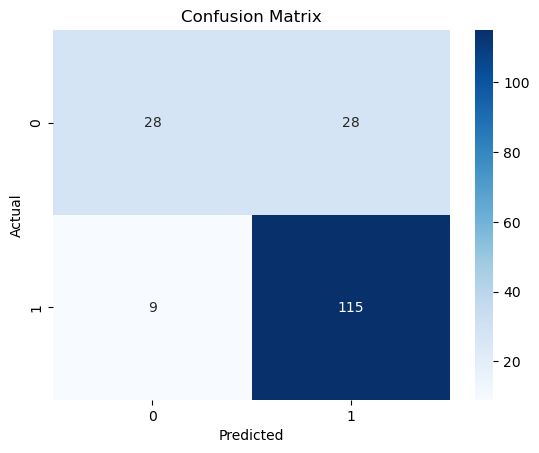

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = rf_model.predict(X_test_processed)

# Metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


<Figure size 1800x1000 with 0 Axes>

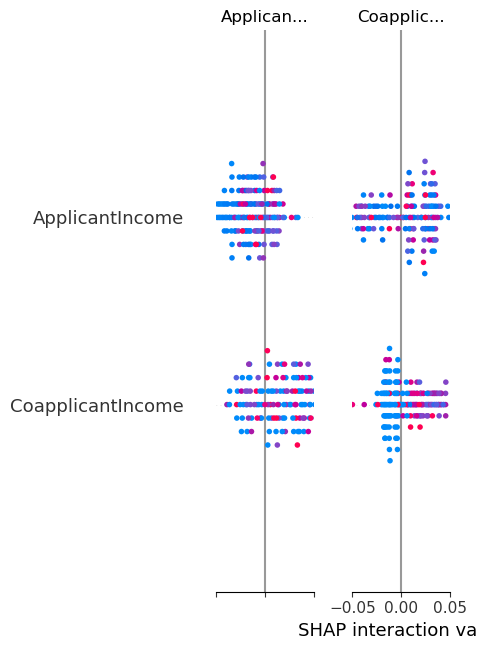

In [26]:
import shap
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

shap.summary_plot(shap_values, X_test_processed, show=False)

axes = plt.gcf().axes

# 1. Set x-limits for all axes
for ax in axes:
    ax.set_xlim(-0.05, 0.05)

# 2. Hide x-axis tick labels for all axes EXCEPT the last one
for ax in axes[:-1]:
    ax.set_xticklabels([])

# 3. Add some spacing
plt.tight_layout(h_pad=2.0)

plt.show()
